## Visualizaciones de casos en Chile con Coronavirus

En base a la página del "minsal" realizaremos algunas visualizaciones del Coronavirus, para eso necesitaremos los siguientes pasos:

1. Web scraping: es decir, extraer la información desde la web
2. Guardar la información en formato de dataframe
3. Generar visualizaciones

Vamos allá!

In [1]:
# Obtenemos algunas librerías necesarias
from requests import get
from bs4 import BeautifulSoup
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import tabula

### 1. Web scraping

In [2]:
url = 'https://www.minsal.cl/nuevo-coronavirus-2019-ncov/casos-confirmados-en-chile-covid-19/'
response = get(url)
html_soup = BeautifulSoup(response.text, 'html.parser')

In [3]:
#Almaceno los links de los archivos PDF
links = []
for table in html_soup.find_all('table'):
    for a in table.find_all('a'):
        links.append(a['href'])
    break

links

['https://www.minsal.cl/wp-content/uploads/2020/03/2020-03-16-Casos-Confirmados.pdf',
 'https://www.minsal.cl/wp-content/uploads/2020/03/2020-03-15-Casos-confirmados.pdf',
 'https://www.minsal.cl/wp-content/uploads/2020/03/2020-03-14-Casos-confirmados.pdf',
 'https://www.minsal.cl/wp-content/uploads/2020/03/2020-03-13-Casos-Confirmados-Covid-19.pdf']

### 2. Guardar la información en formato de dataframe

In [4]:
#Se extrae el pdf desde los links
df1 = tabula.read_pdf(links[0], pages=1)

Got stderr: mar 17, 2020 11:47:28 AM org.apache.pdfbox.pdmodel.font.PDCIDFontType2 <init>
INFORMACIÓN: OpenType Layout tables used in font Arial are not implemented in PDFBox and will be ignored



In [5]:
df = df1[0]
len(df.index)

163

In [6]:

#Seteo columnas del DataFrame, se elimina la primera y última fila, por último se elimina la columna 'Casos confirmados'
df.columns = df.iloc[0].values
df = df.drop([0,len(df.index)-1]).reset_index(drop=True)
df = df.drop(['Casos confirmados'], axis=1)
df=df.rename(columns = {'Centro de salud':'Centro_salud'})
df.columns

Index(['Región', 'Sexo', 'Edad', 'Centro_salud'], dtype='object')

In [7]:
#Se normaliza la columna sexo y Centro_salud, por último se reemplazan por valores que lo preceden
df = df[df["Edad"]!='—'].reset_index(drop=True)
df['Sexo'] = df['Sexo'].str.replace('Fememino','Femenino')
df['Centro_salud'] = df['Centro_salud'].str.replace('\r',' ')
df = df.fillna(method='ffill')

In [8]:
#Se eliminan filas que no tengan sexo
df = df[df["Sexo"]!='—'].reset_index(drop=True)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153 entries, 0 to 152
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Región        153 non-null    object
 1   Sexo          153 non-null    object
 2   Edad          153 non-null    object
 3   Centro_salud  153 non-null    object
dtypes: object(4)
memory usage: 4.9+ KB


In [10]:
#Se eliminan las tuplas que contienen NaN
df_zero_na = df.dropna()

In [11]:
df_zero_na = df_zero_na.reset_index(drop=True)

In [12]:
df_zero_na.head()

,Región,Sexo,Edad,Centro_salud
0,Antofagasta,Femenino,58,Hospital Carlos Cisternas Calama
1,Antofagasta,Masculino,63,Hospital Carlos Cisternas Calama
2,Atacama,Masculino,50,Hospital de Copiapó
3,Valparaíso,Masculino,34,Clínica Ciudad del Mar
4,Metropolitana,Femenino,54,Clínica Alemana


### 3. Generar visualizaciones

In [13]:
df1 = df_zero_na.groupby('Región')['Región'].count().reset_index(name='Cantidad')

In [14]:
df1

,Región,Cantidad
0,Antofagasta,2
1,Araucanía,1
2,Atacama,1
3,Aysén,1
4,Biobío,4
5,Los Lagos,1
6,Los Ríos,1
7,Maule,9
8,Metropolitana,120
9,Valparaíso,1


C:\Users\fsanmartin\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


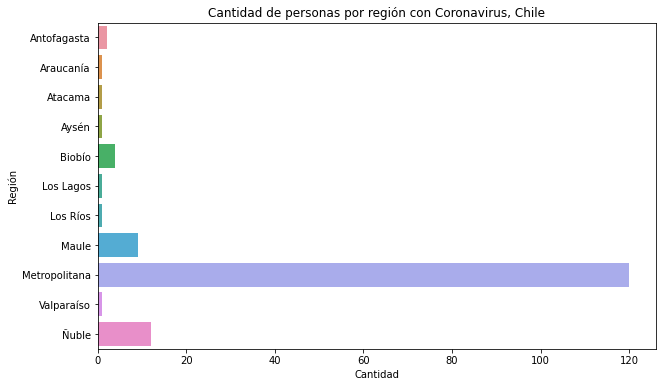

In [15]:
import seaborn as sns
plt.figure(figsize=(10,6))
sns.barplot(x='Cantidad', y='Región', data=df1);
plt.title('Cantidad de personas por región con Coronavirus, Chile')
plt.show();
#df1.plot(kind='bar',x='Región',y='Cantidad');

In [16]:
# Algunos mensajes quedaron clasificados como del tipo string, cambiemos a string

df_zero_na['Edad'] = df_zero_na['Edad'].astype(int)

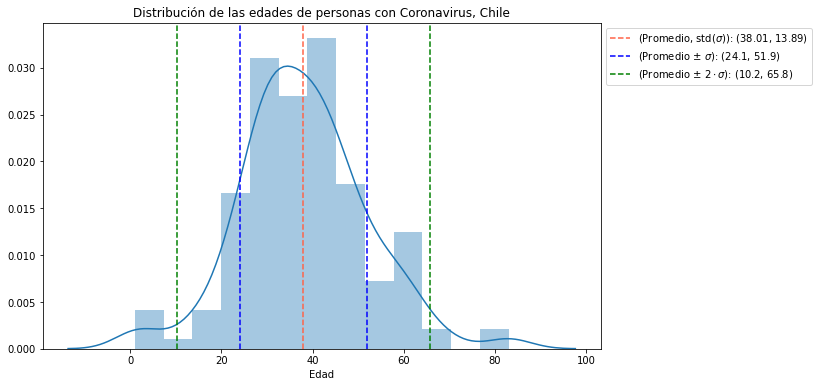

In [17]:
plt.figure(figsize=(10,6))
ax = sns.distplot(df_zero_na['Edad']).set_title('Distribución de las edades de personas con Coronavirus, Chile')
plt.axvline(df_zero_na['Edad'].mean(), color = 'tomato',  label='(Promedio, std($\sigma$)): ('+ str(round(df_zero_na['Edad'].mean(), 2))+ ', ' +str(round(df_zero_na['Edad'].std(), 2))+ ')', linestyle = '--');
plt.axvline(df_zero_na['Edad'].mean() + df_zero_na['Edad'].std(), color = 'blue',  label='(Promedio $\pm$ $\sigma$): ('+ str(round(df_zero_na['Edad'].mean() - df_zero_na['Edad'].std(), 1)) + ', ' + str(round(df_zero_na['Edad'].mean() + df_zero_na['Edad'].std(), 1)) + ')', linestyle = '--');
plt.axvline(df_zero_na['Edad'].mean() - df_zero_na['Edad'].std(), color = 'blue', linestyle = '--');
plt.axvline(df_zero_na['Edad'].mean() + 2*df_zero_na['Edad'].std(), color = 'green',  label='(Promedio $\pm$ $2\cdot\sigma$): ('+ str(round(df_zero_na['Edad'].mean() - 2*df_zero_na['Edad'].std() , 1))+ ', ' + str(round(df_zero_na['Edad'].mean() + 2*df_zero_na['Edad'].std(), 1)) + ')', linestyle = '--');
plt.axvline(df_zero_na['Edad'].mean() - 2*df_zero_na['Edad'].std(), color = 'green', linestyle = '--');
plt.legend(bbox_to_anchor=(1, 1), loc=2)
plt.show();

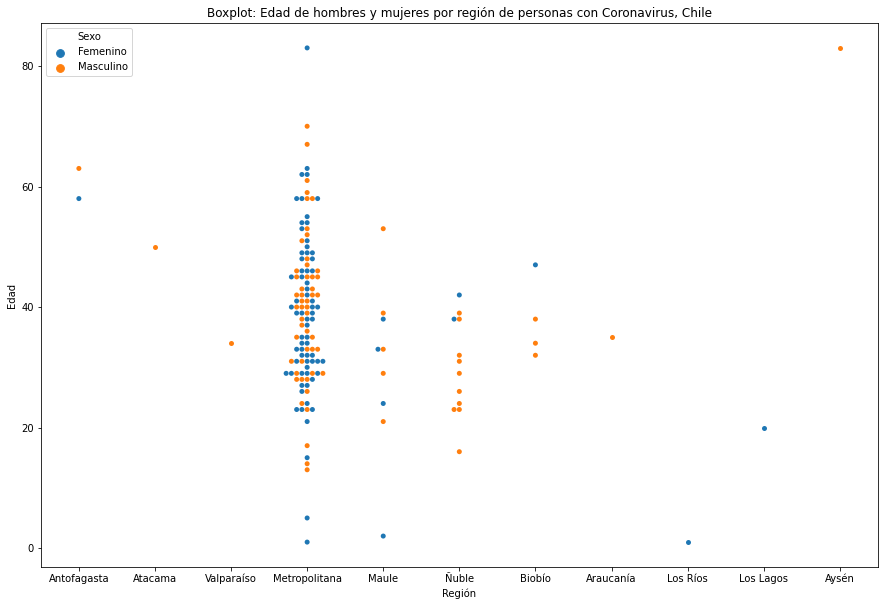

In [18]:
plt.figure(figsize=(15,10))
#ax = sns.boxplot(x="Región", y="Edad", hue="Sexo", data=df_zero_na, palette="Set3")
ax = sns.swarmplot(x="Región", y="Edad", hue="Sexo", data=df_zero_na)
plt.title('Boxplot: Edad de hombres y mujeres por región de personas con Coronavirus, Chile')
plt.show()

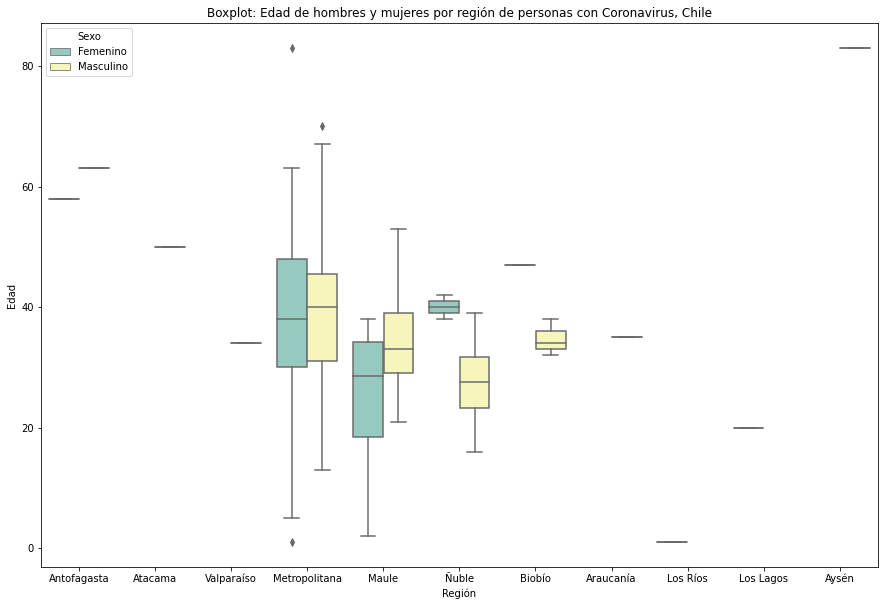

In [19]:
plt.figure(figsize=(15,10))
ax = sns.boxplot(x="Región", y="Edad", hue="Sexo", data=df_zero_na, palette="Set3")
#ax = sns.swarmplot(x="Región", y="Edad", hue="Sexo", data=df_zero_na)
plt.title('Boxplot: Edad de hombres y mujeres por región de personas con Coronavirus, Chile')
plt.show()

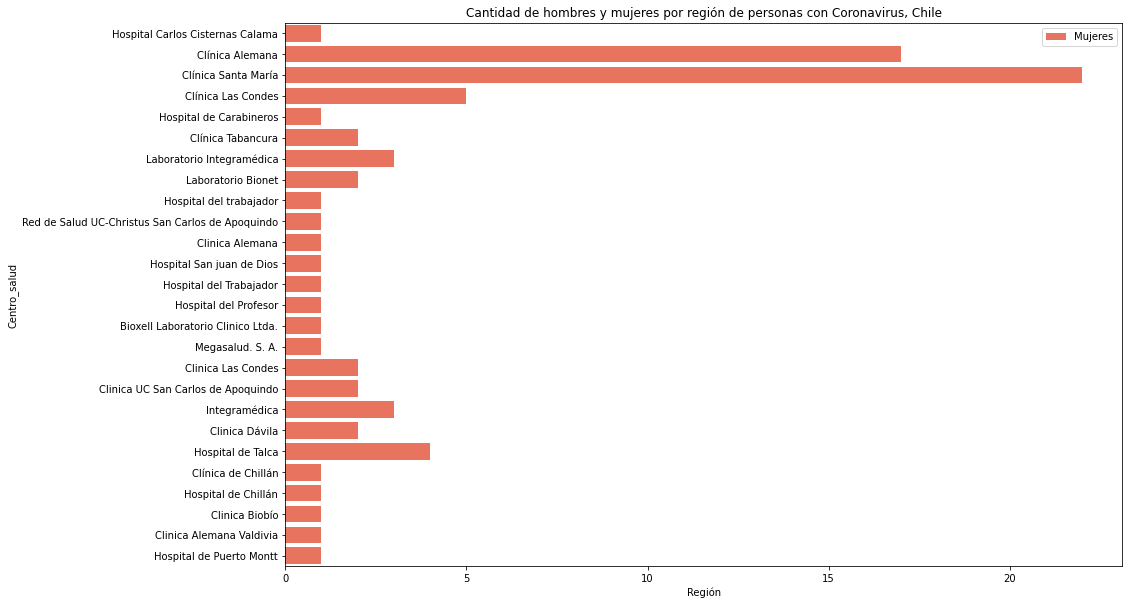

In [20]:
#df_zero_na.groupby(['Región','Sexo']).size().unstack().plot(kind='bar',stacked=True
plt.figure(figsize=(15,10))
#ax = sns.countplot(y= df_zero_na[df_zero_na['Sexo'] == 'Masculino']['Centro_salud'], color = 'darkcyan', label = 'Hombres')
ax = sns.countplot(y= df_zero_na[df_zero_na['Sexo'] == 'Femenino']['Centro_salud'], color = 'tomato', label = 'Mujeres')
plt.title('Cantidad de hombres y mujeres por región de personas con Coronavirus, Chile')
plt.xlabel('Región')
plt.legend(loc='best')
plt.show()

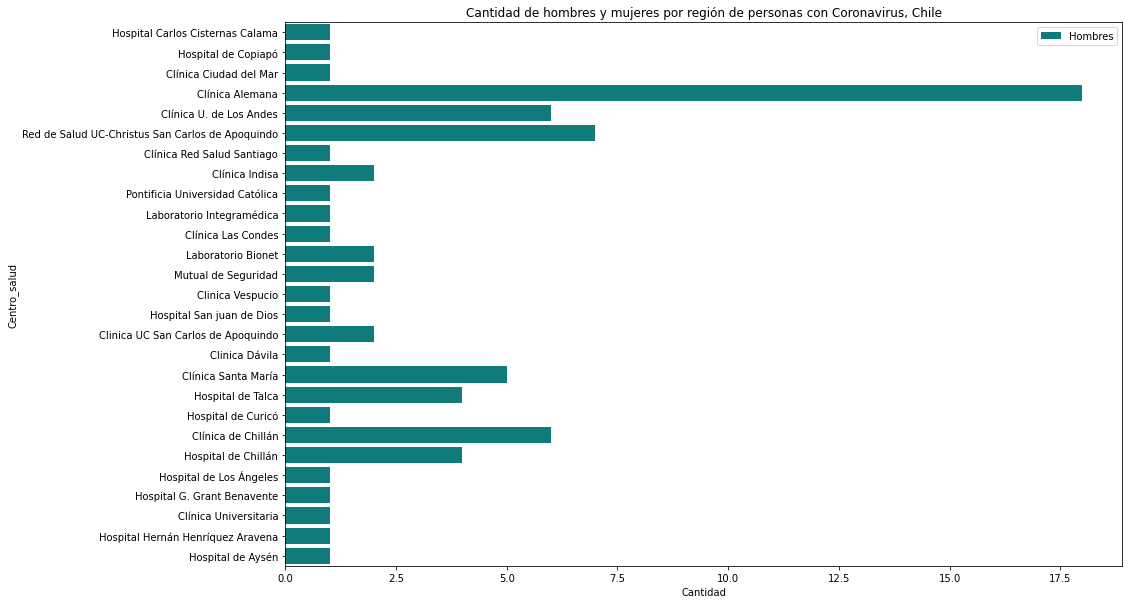

In [21]:
plt.figure(figsize=(15,10))
ax = sns.countplot(y= df_zero_na[df_zero_na['Sexo'] == 'Masculino']['Centro_salud'], color = 'darkcyan', label = 'Hombres')
#ax = sns.countplot(y= df_zero_na[df_zero_na['Sexo'] == 'Femenino']['Centro_salud'], color = 'tomato', label = 'Mujeres')
plt.title('Cantidad de hombres y mujeres por región de personas con Coronavirus, Chile')
plt.xlabel('Cantidad')
plt.legend(loc='best')
plt.show()

In [22]:
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="Covid19-CL", timeout=10)
location = geolocator.geocode("Región Metropolitana, Chile")
print(location.address)
print((location.latitude, location.longitude))

San Pablo 2966 5to Piso, Santiago, Región Metropolitana, Chile, 2966, Avenida San Pablo, Quinta Normal, Provincia de Santiago, Región Metropolitana de Santiago, 8350485, Chile
(-33.4354421, -70.6766162)


In [23]:
geolocator.geocode('Ñuñoa, Región Metropolitana')

Location(Ñuñoa, Provincia de Santiago, Región Metropolitana de Santiago, Chile, (-33.4543304, -70.60058198319726, 0.0))

In [24]:
from geopy.extra.rate_limiter import RateLimiter

df_loc = df_zero_na
df_loc['Address'] = 'Región ' + df_loc['Región'] + ', Chile'
lat = []
lon = []
for index, row in df_loc.iterrows():
    location = geolocator.geocode(row['Address'])
    lat.append(location.latitude)
    lon.append(location.longitude)
df_loc['lat'] = lat
df_loc['lon'] = lon
df_loc

,Región,Sexo,Edad,Centro_salud,Address,lat,lon
0,Antofagasta,Femenino,58,Hospital Carlos Cisternas Calama,"Región Antofagasta, Chile",-22.455864,-68.927458
1,Antofagasta,Masculino,63,Hospital Carlos Cisternas Calama,"Región Antofagasta, Chile",-22.455864,-68.927458
2,Atacama,Masculino,50,Hospital de Copiapó,"Región Atacama, Chile",-26.385295,-70.047757
3,Valparaíso,Masculino,34,Clínica Ciudad del Mar,"Región Valparaíso, Chile",-32.786024,-71.203457
4,Metropolitana,Femenino,54,Clínica Alemana,"Región Metropolitana, Chile",-33.435442,-70.676616
...,...,...,...,...,...,...,...
148,Biobío,Femenino,47,Clinica Biobío,"Región Biobío, Chile",-36.964842,-72.928386
149,Araucanía,Masculino,35,Hospital Hernán Henríquez Aravena,"Región Araucanía, Chile",-38.671012,-72.256458
150,Los Ríos,Femenino,1,Clinica Alemana Valdivia,"Región Los Ríos, Chile",-39.819592,-73.243910
151,Los Lagos,Femenino,20,Hospital de Puerto Montt,"Región Los Lagos, Chile",-42.898024,-72.438891


In [25]:
import folium
from folium.plugins import MarkerCluster

map1 = folium.Map(
    location=[-35.675148,-71.5429688],
    tiles='OpenStreetMap',
    zoom_start=4.5,
)
mc = MarkerCluster()

for row in df_loc.itertuples():
    mc.add_child(folium.Marker(location=[row.lat, row.lon], popup=folium.Popup('Edad: ' + str(row.Edad) + ' ' + row.Sexo + '  (' + row.Centro_salud + ')', max_width=90)))
mc.add_to(map1)
map1

In [26]:
df_rm_loc = df_loc[df_loc['Región'] == 'Metropolitana']

In [27]:
df_rm_loc.columns

Index(['Región', 'Sexo', 'Edad', 'Centro_salud', 'Address', 'lat', 'lon'], dtype='object')

In [28]:
df_rm_loc = df_rm_loc.loc[:, ['Región', 'Sexo', 'Edad', 'Centro_salud', 'Address']]

In [29]:
df_rm_loc['Centro_salud'].value_counts().index

Index(['Clínica Alemana', 'Clínica Santa María',
       'Red de Salud UC-Christus San Carlos de Apoquindo',
       'Clínica Las Condes', 'Clínica U. de Los Andes',
       'Laboratorio Integramédica', 'Clinica UC San Carlos de Apoquindo',
       'Laboratorio Bionet', 'Integramédica', 'Clinica Dávila',
       'Mutual de Seguridad', 'Clinica Las Condes', 'Clínica Tabancura',
       'Hospital San juan de Dios', 'Clínica Indisa', 'Clinica Alemana',
       'Hospital del Profesor', 'Clinica Vespucio', 'Megasalud. S. A.',
       'Bioxell Laboratorio Clinico Ltda.', 'Hospital del trabajador',
       'Clínica Red Salud Santiago', 'Hospital del Trabajador',
       'Hospital de Carabineros', 'Pontificia Universidad Católica'],
      dtype='object')

In [30]:
conditions = [(df_rm_loc['Centro_salud'] == 'Clínica Alemana') | (df_rm_loc['Centro_salud'] == 'Clínica Tabancura'),
              (df_rm_loc['Centro_salud'] == 'Clínica Santa María') | (df_rm_loc['Centro_salud'] == 'Clínica Indisa'),
              (df_rm_loc['Centro_salud'] == 'Red de Salud UC-Christus San Carlos de Apoquindo') | (df_rm_loc['Centro_salud'] == 'Clínica U. de Los Andes') | (df_rm_loc['Centro_salud'] == 'Clínica Las Condes') | (df_rm_loc['Centro_salud'] == 'Laboratorio Integramédica'),
              (df_rm_loc['Centro_salud'] == 'Clínica Red Salud Santiago'),
              (df_rm_loc['Centro_salud'] == 'Hospital de Carabineros')]
choices = ['Vitacura', 'Providencia', 'Las Condes', 'Estación central', 'Ñuñoa'] 
df_rm_loc['comuna'] = np.select(conditions, choices, default= None)

In [31]:
df_rm_loc['comuna'].value_counts()

Vitacura            37
Providencia         29
Las Condes          24
Estación central     1
Ñuñoa                1
Name: comuna, dtype: int64

In [32]:
df_rm_loc['New_Address'] = df_rm_loc['comuna'] +","+df_rm_loc['Address']
lat = []
lon = []
for index, row in df_rm_loc.iterrows():
    location = geolocator.geocode(row['New_Address'])
    lat.append(location.latitude)
    lon.append(location.longitude)
df_rm_loc['lat'] = lat
df_rm_loc['lon'] = lon
df_rm_loc

,Región,Sexo,Edad,Centro_salud,Address,comuna,New_Address,lat,lon
4,Metropolitana,Femenino,54,Clínica Alemana,"Región Metropolitana, Chile",Vitacura,"Vitacura,Región Metropolitana, Chile",-33.380206,-70.565796
5,Metropolitana,Femenino,40,Clínica Santa María,"Región Metropolitana, Chile",Providencia,"Providencia,Región Metropolitana, Chile",-33.428838,-70.611337
6,Metropolitana,Masculino,58,Clínica Alemana,"Región Metropolitana, Chile",Vitacura,"Vitacura,Región Metropolitana, Chile",-33.380206,-70.565796
7,Metropolitana,Masculino,17,Clínica Alemana,"Región Metropolitana, Chile",Vitacura,"Vitacura,Región Metropolitana, Chile",-33.380206,-70.565796
8,Metropolitana,Femenino,83,Clínica Las Condes,"Región Metropolitana, Chile",Las Condes,"Las Condes,Región Metropolitana, Chile",-33.424788,-70.517498
...,...,...,...,...,...,...,...,...,...
119,Metropolitana,Femenino,31,Clínica Santa María,"Región Metropolitana, Chile",Providencia,"Providencia,Región Metropolitana, Chile",-33.428838,-70.611337
120,Metropolitana,Femenino,1,Clínica Santa María,"Región Metropolitana, Chile",Providencia,"Providencia,Región Metropolitana, Chile",-33.428838,-70.611337
121,Metropolitana,Femenino,5,Clínica Santa María,"Región Metropolitana, Chile",Providencia,"Providencia,Región Metropolitana, Chile",-33.428838,-70.611337
122,Metropolitana,Masculino,45,Clínica Santa María,"Región Metropolitana, Chile",Providencia,"Providencia,Región Metropolitana, Chile",-33.428838,-70.611337


In [33]:
map2 = folium.Map(
    location=[-35.675148,-71.5429688],
    tiles='OpenStreetMap',
    zoom_start=4.5,
)
mc = MarkerCluster()

for row in df_rm_loc.itertuples():
    mc.add_child(folium.Marker(location=[row.lat, row.lon], popup=folium.Popup('Edad: ' + str(row.Edad) + ' ' + row.Sexo + '  (' + row.Centro_salud + ')', max_width=90)))
mc.add_to(map2)
map2